# Project 2: Continuous Control

This notebook provides the main part of code for training the agent. Beyond this notebook, the Python files 'actor_critic_networks.py' and 'deep_det_policy_grad_agent.py' are necessary for successfully solving this continuous control project.

### 1. Set the framework

First, load necessary packages.

In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from collections import deque
from deep_det_policy_grad_agent import Agent

Now, start the environment.

In [2]:
env = UnityEnvironment(file_name='C:/Users/DNEUHAE/Desktop/DRL/p2_continuous-control/Reacher_Windows_x86_64/Reacher.exe')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Initialize the agent

In [3]:
from actor_critic_networks import Actor_2HL_BN, Critic_2HL_BN, Actor_1HL, Critic_3HL_leaky

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)

# extract size information for action space and state space  
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size

Now, we initialize two actor-critic-agents. The first one ('actor_critic_2x2_BN') has an actor network with 2 hidden layers and a critic network with 2 hidden layers, each equipped with batch normalization. The second agent ('actor_critic_1x3_leaky') has an actor network with 1 hidden layer and a critic network with 3 hidden layers, each equipped with leaky relus. Thus, the difference between the actor-critic-agents is the architecture of the neural nets.

In [4]:
actor_critic_2x2_BN = Agent(action_size=action_size, state_size=state_size, random_seed=0, actor_net=Actor_2HL_BN, critic_net=Critic_2HL_BN)
actor_critic_1x3_leaky = Agent(action_size=action_size, state_size=state_size, random_seed=0, actor_net=Actor_1HL, critic_net=Critic_3HL_leaky)

### 3. Train the agents via Deep Deterministic Policy Gradient

In [5]:
def ddpg(n_episodes, max_t, agent, pth_filename_act, pth_filename_cri):
    """
    Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int): number of training episodes
        max_t (int): maximum number of timesteps per episode
        agent (Agent object): Actor-Critic-Agent with specified network architecture 
        pth_filename_act (str): name for the '*.pth'-file for actor
        pth_filename_cri (str): name for the '*.pth'-file for critic
    """
    
    scores = []                                                # list containing scores from each episode   
    scores_window = deque(maxlen=100)                          # store only the last 100 scores
    actor_critic_agent = agent                                 # specify agent's neural networks architectures
    
    for n_episode in range(1, n_episodes+1):                   # run n_episodes
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)                           # initialize the score (for each agent)
        
        for t in range(max_t):                                 # run for maximum of max_t timesteps 
            actions = actor_critic_agent.act(states)           # get the actions
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations         # get the states
            rewards = env_info.rewards                         # get the rewards
            dones = env_info.local_done                        # is the episode complete or not
            for i in range(20):                                # for all 20 agents in parallel: execute next "step" --> train
                actor_critic_agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], t)
            states = next_states
            score += rewards
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        score = score.mean()                                   # get the mean score of the episode (over all agents)
        scores_window.append(score)                            # store the score in the queue
        scores.append(score)                                   # store the score in the list (for plotting)
        
        # print mean score per episode
        print('\rEpisode {}\tScore: {:.2f}'.format(n_episode, score), end="")

        # calculate mean score over the last 100 episodes
        mean_sc = np.mean(scores_window)                       
        if n_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(n_episode, mean_sc))
            
        if len(scores_window) == 100 and mean_sc >= 30 :
            print('\rEnvironment solved in {} episodes, mean score: {:.2f}'.format(n_episode, mean_sc))
            torch.save(agent.actor_local.state_dict(), pth_filename_act)
            torch.save(agent.critic_local.state_dict(), pth_filename_cri)
            break
            
    return scores

#### 3.1 Actor-Critic-Agent via 'actor_critic_2x2_BN'

In [7]:
scores = ddpg(n_episodes=5000, 
              max_t=1000, 
              agent=actor_critic_2x2_BN, 
              pth_filename_act='actor_2x2_BN.pth',
              pth_filename_cri='critic_2x2_BN.pth'
             )

Episode 100	Average Score: 29.59
Environment solved in 102 episodes, mean score: 30.36


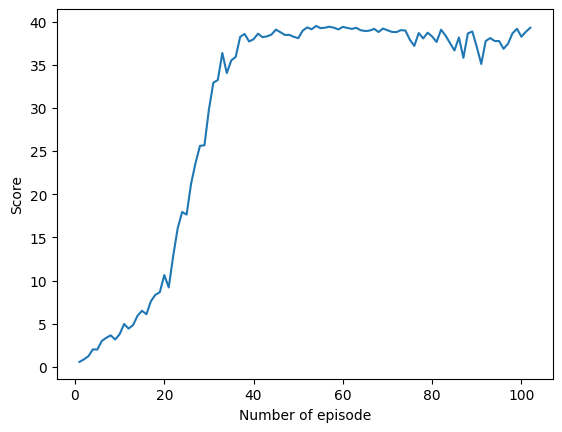

In [8]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Number of episode')
plt.savefig('C:/Users/DNEUHAE/Desktop/DRL/p2_continuous-control/actor_critic_2x2_BN.png', bbox_inches='tight')
plt.show()

#### 3.2 Actor-Critic-Agent via 'actor_critic_1x3_leaky'

In [9]:
scores = ddpg(n_episodes=5000, 
              max_t=1000, 
              agent=actor_critic_1x3_leaky, 
              pth_filename_act='actor_1x3_leaky.pth',
              pth_filename_cri='critic_1x3_leaky.pth'
             )

Episode 100	Average Score: 30.04
Environment solved in 100 episodes, mean score: 30.04


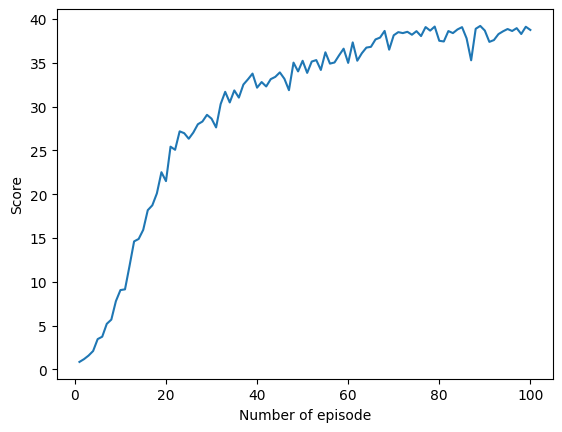

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Number of episode')
plt.savefig('C:/Users/DNEUHAE/Desktop/DRL/p2_continuous-control/actor_critic_1x3_leaky.png', bbox_inches='tight')
plt.show()

### 4. Load trained agents and see models in action

In [7]:
agent = actor_critic_2x2_BN
agent.actor_local.load_state_dict(torch.load('actor_2x2_BN.pth'))
agent.critic_local.load_state_dict(torch.load('critic_2x2_BN.pth'))

#agent = actor_critic_1x3_leaky
#agent.actor_local.load_state_dict(torch.load('actor_1x3_leaky.pth'))
#agent.critic_local.load_state_dict(torch.load('critic_1x3_leaky.pth'))

<All keys matched successfully>

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
states = env_info.vector_observations                  # get the current state (for each agent)        
score = np.zeros(num_agents)                           # initialize the score (for each agent)   

while True:
    actions = agent.act(states)                        # select the actions
    env_info = env.step(actions)[brain_name]           # send the action to the environment
    next_states = env_info.vector_observations         # get next states
    rewards = env_info.rewards                         # get the rewards
    dones = env_info.local_done                        # see if episode has finished
    score += rewards                                   # update score by reward
    states = next_states                               # roll over the state to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break        
                   
print('Total score (averaged over agents) this episode: {}'.format(np.mean(score)))     

Total score (averaged over agents) this episode: 39.41949911890551


In [4]:
env.close()